In [241]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

In [242]:
data_path = '/kaggle/input/dog-and-cat-classification-dataset/PetImages/'
samples_count = 1000 # размер подвыборки
img_size = (128, 128) # разрешение изображений

Объявляю функцию для загрузки и преобразования изображений. Беру 1 канал, т.к. точность предсказаний от этого почти не страдает, при этом объем данных уменьшается в 3 раза

In [243]:
def load_and_preprocess_img(images, labels, class_name):
    dir_path = os.path.join(data_path, class_name)
    img_names = np.random.choice(os.listdir(dir_path), samples_count) # случайно выбираем 1000 названий изображений
    for img_name in tqdm(img_names):
        img_path = os.path.join(dir_path, img_name)
        img = Image.open(img_path).convert('L').resize(img_size) # конвертируем в 1 канал (greyscale)
        images.append(img)
        labels.append(0) if class_name == 'Cat' else labels.append(1)

Загружаю изображения 2-ух классов (кошек и собак), разделяя их по label-ам: 0 - кошка, 1 - собака

In [244]:
def load_data():
    images = []
    labels = []
    load_and_preprocess_img(images, labels, 'Cat')
    load_and_preprocess_img(images, labels, 'Dog')
    return np.array(images), np.array(labels)

In [245]:
X, y = load_data()

100%|██████████| 1000/1000 [00:05<00:00, 197.22it/s]


В качестве примера отрисовываю по 5 изображений из каждого класса

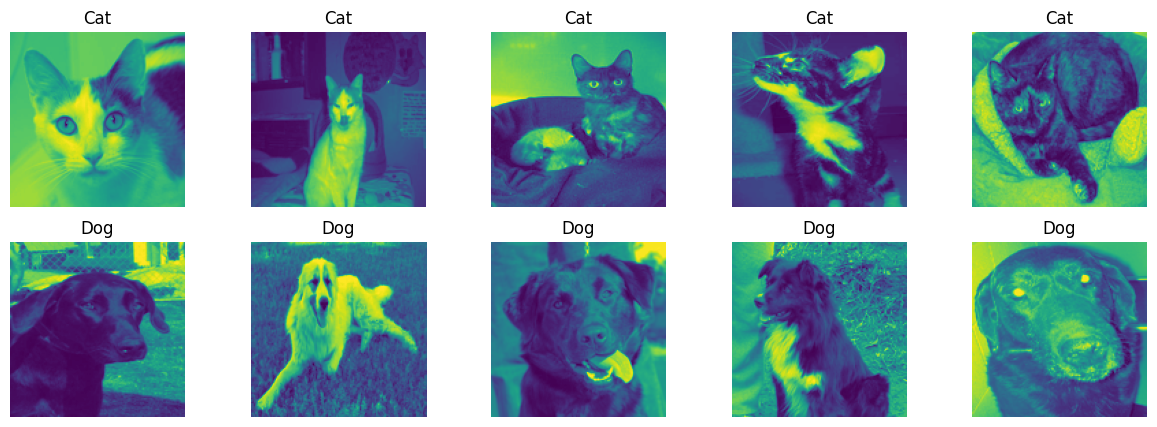

In [246]:
plt.figure(figsize=(15, 5))
for i in range(5):
    plt.subplot(2, 5, i + 1)
    plt.imshow(X[i])
    plt.title('Cat' if y[i] == 0 else 'Dog')
    plt.axis('off')
    
    plt.subplot(2, 5, i + 6)
    plt.imshow(X[i + samples_count])
    plt.title('Cat' if y[i + samples_count] == 0 else 'Dog')
    plt.axis('off')

In [247]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) # разделяем выборку

Далее преобразовываю изображение в samples_count векторов (128 * 128 * 1) + нормирую т.к. изображения хранятся в байтах

In [248]:
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

scaler = StandardScaler()
X_train_norm = scaler.fit_transform(X_train_flat)
X_test_norm = scaler.transform(X_test_flat)

В качестве базовой модели выбрал SVC с Radial Basis Function ядром

In [249]:
base_model = SVC(kernel='rbf')
base_model.fit(X_train_norm, y_train)

SVC(random_state=42)

In [250]:
base_prediction = base_model.predict(X_test_norm)
accuracy = accuracy_score(y_test, base_prediction)
print(accuracy)

0.6525


Получена неплохая точность, учитывая размер выборки и изображений

Теперь преобразовываю данные с использованием PCA

In [251]:
pca = PCA()
X_train_pca = pca.fit_transform(X_train_norm) # тут получаем центрированные данные * матрица из главных компонент (векторов)
X_test_pca = pca.transform(X_test_norm)

Вывожу информацию по тому, сколько дисперсии "объясняет" каждая компонента (λ \ ∑λ)

In [252]:
print(pca.explained_variance_ratio_)

[2.04998250e-01 1.15080312e-01 7.85421666e-02 ... 9.03406644e-36
 6.91934461e-36 4.69840382e-36]


Видим, что первая компонента объясняет ~20% дисперсии, вторая ~10% и т.д.

Вывожу кумулятивную сумму (aka префиксная сумма) для того, чтобы в дальнейшем находить необходимое кол-во главных компонент, объясняющих заданную дисперсию.

In [253]:
csum = np.cumsum(pca.explained_variance_ratio_)
print(csum)

[0.20499825 0.32007856 0.39862073 ... 1.         1.         1.        ]


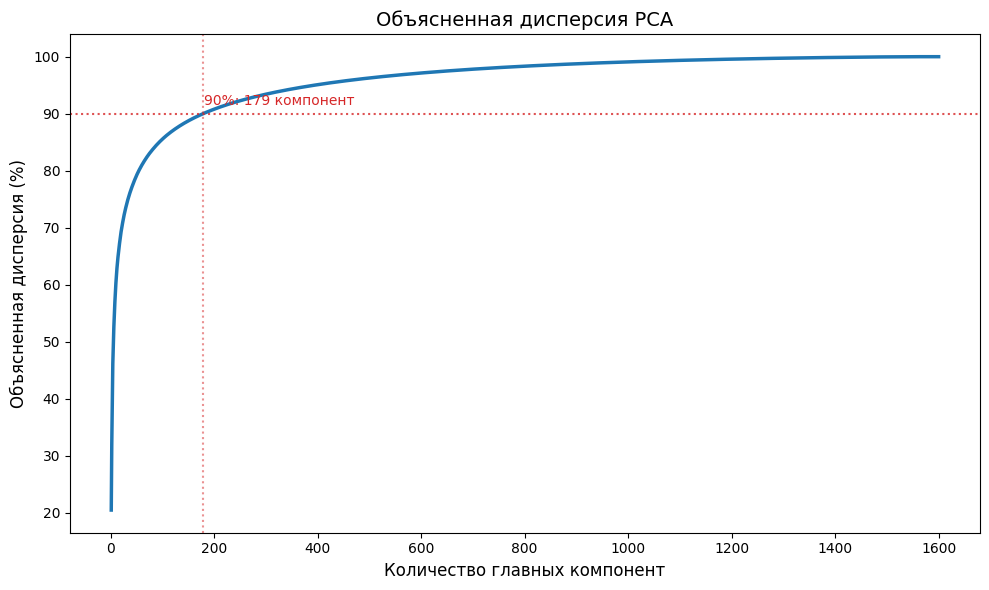

In [254]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(csum) + 1), csum * 100, 
         linewidth=2.5, color='#1f77b4')
# Горизонтальная линия для порога
plt.axhline(y=90, color='#d62728', linestyle=':', alpha=0.8)
components_count_90 = np.argmax(csum >= 0.90) + 1 # нахождение точки порога
# аннотация
plt.text(components_count_90 + 0.5, 91, f'90%: {components_count_90} компонент',
         color='#d62728', fontsize=10, va='bottom')
# Вертикальные линиия в точке порога
plt.axvline(x=components_count_90, color='#d62728', linestyle=':', alpha=0.5)

plt.title('Объясненная дисперсия PCA', fontsize=14)
plt.xlabel('Количество главных компонент', fontsize=12)
plt.ylabel('Объясненная дисперсия (%)', fontsize=12)

plt.tight_layout()
plt.show()

Из графика видно, что оптимальное значение лежит как раз около >90% объясненной дисперсии, однако это не означает, что именно это значение подойдет для нашей модели

Далее определяю функцию, обучающую переданную модель на преобразованных PCA данных, где остается столько компонент, сколько необходимо для объяснения заданной дисперсии (от 10% до 100% с шагом 10%). Метрику точности для каждого кол-ва компонент складываем в массив для вывода графика

In [255]:
def get_pca_accurancies(model):
    accuracies = []
    variances = np.linspace(0.1, 0.9, 9)
    for i in variances:
        components_count = np.argmax(csum >= i) + 1 # кол-во компонентов, необходимых для объяснения i*100% дисперсии
        X_train_pca_ncomp = X_train_pca[:, :components_count] # обрезаем матрицу до нужного кол-ва компонент
        X_test_pca_ncomp = X_test_pca[:, :components_count]
        model.fit(X_train_pca_ncomp, y_train) # обучаем модель
        prediction = model.predict(X_test_pca_ncomp)
        accuracy = accuracy_score(prediction, y_test)
        accuracies.append((components_count, accuracy)) # добавляем в массив tuple вида (кол-во компонент, точность)
    
    # добавляем результат обучения на данных, преобразованных PCA, объясняющих 100% дисперсии
    # делаю это отдельно из-за ошибки вычислений с плавающей запятой
    model.fit(X_train_pca_ncomp, y_train)
    prediction = model.predict(X_test_pca_ncomp)
    accuracy = accuracy_score(y_test, prediction)
    accuracies.append((X_train_pca.shape[1], accuracy))
    print(fr"{model} точности на кол-во компонент: {accuracies}")
    return accuracies

Также сразу сраним влияние PCA как на базовую модель (SVC с Radial Basis Function ядром), так и на логистическую регрессию и Random Forest. Получаю точности для каждой из моделей

In [256]:
svc = SVC(kernel='rbf')
logreg = LogisticRegression(max_iter=100000)
rand_forest = RandomForestClassifier(n_estimators=100, max_depth=15, n_jobs=-1)

svc_acc = get_pca_accurancies(svc)
logreg_acc = get_pca_accurancies(logreg)
rand_forest_acc = get_pca_accurancies(rand_forest)

SVC(random_state=42) точности на кол-во компонент: [(1, 0.555), (1, 0.555), (2, 0.5875), (4, 0.595), (6, 0.6275), (10, 0.6175), (22, 0.645), (55, 0.635), (179, 0.6525), (1600, 0.6525)]
LogisticRegression(max_iter=100000) точности на кол-во компонент: [(1, 0.5325), (1, 0.5325), (2, 0.5225), (4, 0.5225), (6, 0.545), (10, 0.51), (22, 0.5425), (55, 0.54), (179, 0.5475), (1600, 0.5475)]
RandomForestClassifier(max_depth=15, n_jobs=-1) точности на кол-во компонент: [(1, 0.555), (1, 0.5575), (2, 0.5925), (4, 0.615), (6, 0.62), (10, 0.6425), (22, 0.605), (55, 0.6175), (179, 0.6475), (1600, 0.605)]


Видно, что для объяснения 90% дисперсии необходимо в **~9 раз** меньше компонентов, для 80% в **~29 раз**, для 70% в **~72 раза**, для 60% в **~160 раз**, при этом точность моделей с таким кол-вом компонент почти не меняется.

Далее на графике вывожу зависимость точности от кол-ва компонент PCA для каждой из моделей

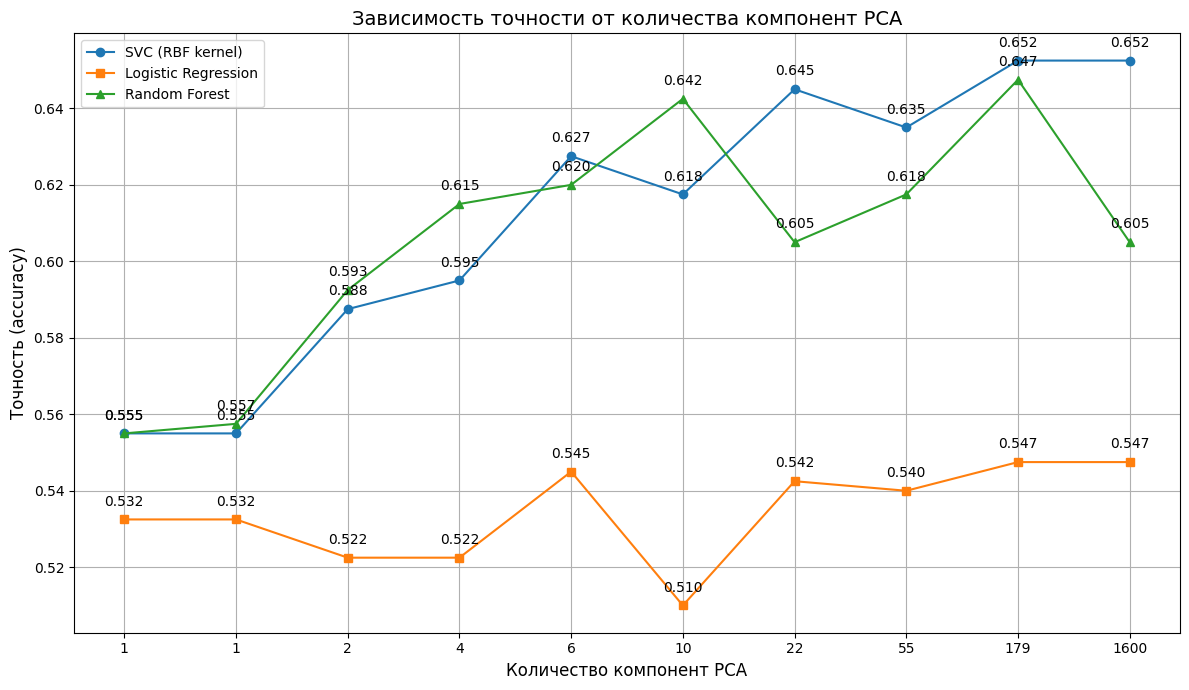

In [257]:
# Извлечение данных с использованием индексов
svc_values = [x[1] for x in svc_acc]
logreg_values = [x[1] for x in logreg_acc]
rf_values = [x[1] for x in rand_forest_acc]

# Создаем список индексов для позиционирования точек
indices = list(range(len(svc_acc)))

plt.figure(figsize=(12, 7))

plt.plot(indices, svc_values, marker='o', label='SVС (RBF kernel)')
plt.plot(indices, logreg_values, marker='s', label='Logistic Regression')
plt.plot(indices, rf_values, marker='^', label='Random Forest')

plt.title('Зависимость точности от количества компонент PCA', fontsize=14)
plt.xlabel('Количество компонент PCA', fontsize=12)
plt.ylabel('Точность (accuracy)', fontsize=12)

# Настройка подписей на оси X
component_values = [x[0] for x in svc_acc]  # реальные значения компонент
plt.xticks(indices, component_values)

# Добавление аннотаций
for i, (comp, acc) in enumerate(svc_acc):
    plt.annotate(f'{acc:.3f}', (i, acc), textcoords="offset points", xytext=(0,10), ha='center')
for i, (comp, acc) in enumerate(logreg_acc):
    plt.annotate(f'{acc:.3f}', (i, acc), textcoords="offset points", xytext=(0,10), ha='center')
for i, (comp, acc) in enumerate(rand_forest_acc):
    plt.annotate(f'{acc:.3f}', (i, acc), textcoords="offset points", xytext=(0,10), ha='center')

plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

Видно, что для логистической регрессии и случайного леса точность снижается лишь до какого-то момента, далее с уменьшением компонент она может возрасти. Получается некая горка. Также видно, что объем данных влияет на логистическую регрессию меньше, чем на SVC и Random Forest (проверил около 10 раз)

Далее вывожу изображения после преобразования PCA (100% var). Должны остаться данные, которые являются наиболее информативными

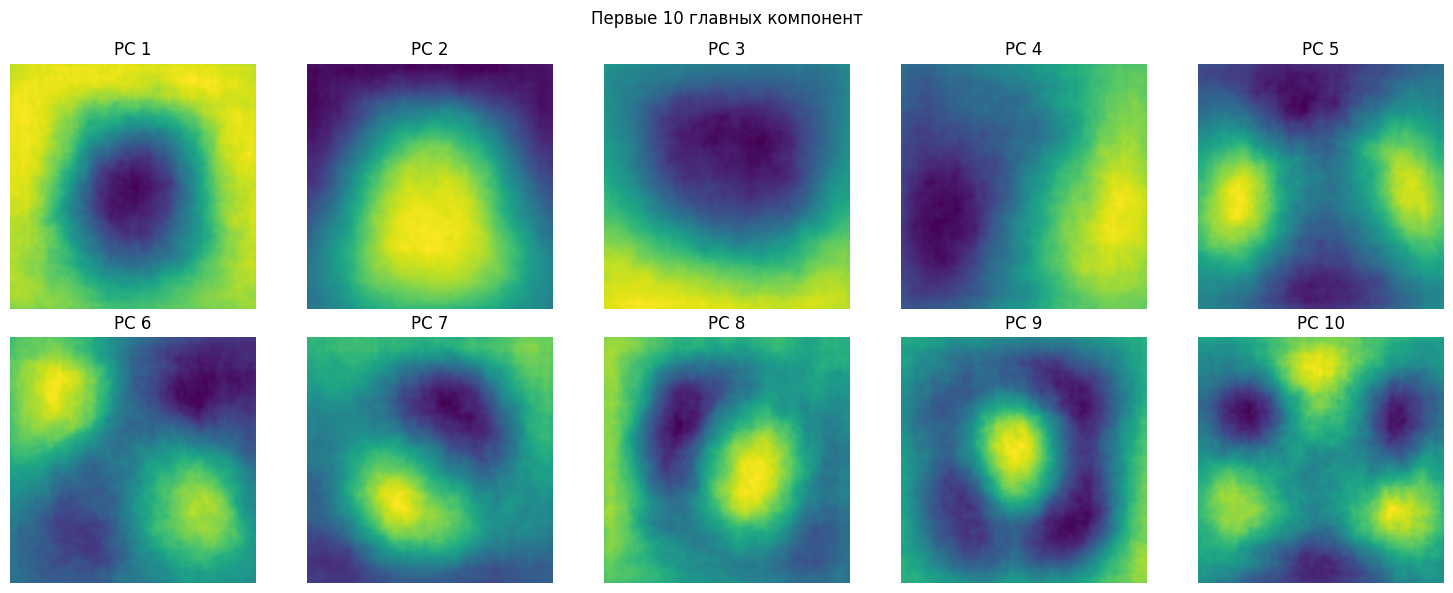

In [258]:
n_components_to_show = min(10, pca.components_.shape[0])
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.ravel()

for idx in range(n_components_to_show):
    component = pca.components_[idx].reshape(img_size[0], img_size[1], 1) # преобразовываю вектор компоненты обратно в изображение
    component = (component - component.min()) / (component.max() - component.min()) # нормирую для отрисовки
    axes[idx].imshow(component)
    axes[idx].axis('off')
    axes[idx].set_title(f'PC {idx+1}')

plt.suptitle('Первые 10 главных компонент')
plt.tight_layout()